In [81]:
#IMPORTING THE LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import yfinance as yf
from datetime import datetime
from pandas.tseries.offsets import BDay
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [82]:
tf.config.list_physical_devices('GPU')

[]

In [83]:
# Fetch ExxonMobil's stock data
start = datetime(2021, 1, 1)  # Start date
end = datetime.now()  # Retrieves data up to the current date
df = yf.download('XOM', start, end)
original_df = df.copy()

# Selecting relevant features
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%%**********************]  1 of 1 completed


In [84]:
# Scaling data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [85]:
# Creating dataset for model testing and training
def create_dataset(data, time_step=60):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        x.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 3])  # 3 is the index of 'Close' in scaled_data
    return np.array(x), np.array(y)


In [86]:
# Setting window size and splitting data
time_step = 60
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [87]:
# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Building the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 5)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [88]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [89]:
# Fitting the model with early stopping
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1)#, callbacks=[early_stopping])


Epoch 1/50
17/17 [==============================] - 4s 116ms/step - loss: 0.2037 - val_loss: 0.0352
Epoch 2/50
17/17 [==============================] - 1s 78ms/step - loss: 0.0487 - val_loss: 0.0206
Epoch 3/50
17/17 [==============================] - 1s 78ms/step - loss: 0.0422 - val_loss: 0.0203
Epoch 4/50
17/17 [==============================] - 1s 80ms/step - loss: 0.0360 - val_loss: 0.0193
Epoch 5/50
17/17 [==============================] - 1s 77ms/step - loss: 0.0355 - val_loss: 0.0198
Epoch 6/50
17/17 [==============================] - 1s 77ms/step - loss: 0.0334 - val_loss: 0.0204
Epoch 7/50
17/17 [==============================] - 1s 80ms/step - loss: 0.0322 - val_loss: 0.0570
Epoch 8/50
17/17 [==============================] - 1s 79ms/step - loss: 0.0370 - val_loss: 0.0424
Epoch 9/50
17/17 [==============================] - 1s 78ms/step - loss: 0.0336 - val_loss: 0.0256
Epoch 10/50
17/17 [==============================] - 1s 78ms/step - loss: 0.0280 - val_loss: 0.0257
Epoch 11

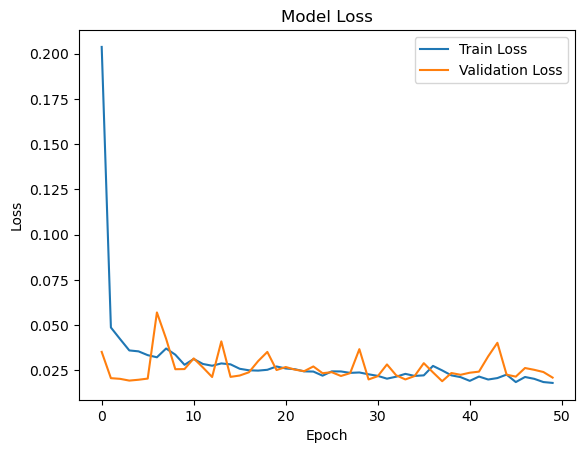

In [90]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [91]:
# Calculate the number of business days until March 1, 2024
end_prediction_date = datetime(2024, 3, 1)
n_days = np.busday_count(end.strftime('%Y-%m-%d'), end_prediction_date.strftime('%Y-%m-%d'))

In [92]:
# Preparing the last known data as the initial input for prediction
last_known_data = scaled_data[-time_step:]

In [93]:
# Predicting future prices
future_predictions = []
current_input = last_known_data.reshape(1, time_step, 5)

for i in range(n_days):
    next_day_prediction = model.predict(current_input)[0, 0]  # Get the predicted closing price
    future_predictions.append(next_day_prediction)

    # Update the last day's data in current_input with the predicted closing price
    next_input = current_input[:, -1, :]
    next_input[0, 3] = next_day_prediction  # 3 is the index of the 'Close' feature

    # Updating the current input to include the next day's data
    current_input = np.append(current_input[:, 1:, :], [next_input.reshape(1, 5)], axis=1)


1/1 [==============================] - 0s 19ms/step


In [98]:
# Transforming predictions back to the original scale
future_predictions = np.array(future_predictions)
future_predictions_scaled = scaler.inverse_transform(np.column_stack((future_predictions, np.zeros((future_predictions.shape[0], 4)))))


# Print the predicted stock price for the last date
last_date = future_dates[-1]  # Access the last date
last_price = future_predictions_scaled[-1, 0]  # Access the last prediction

print(f"Predicted price on 1 March 2024: {last_price:.2f}")



Predicted price on 1 March 2024: 109.89


In [99]:
# Creating a date range for future predictions
future_dates = pd.date_range(start=original_df.index[-1] + BDay(1), periods=n_days, freq='B')

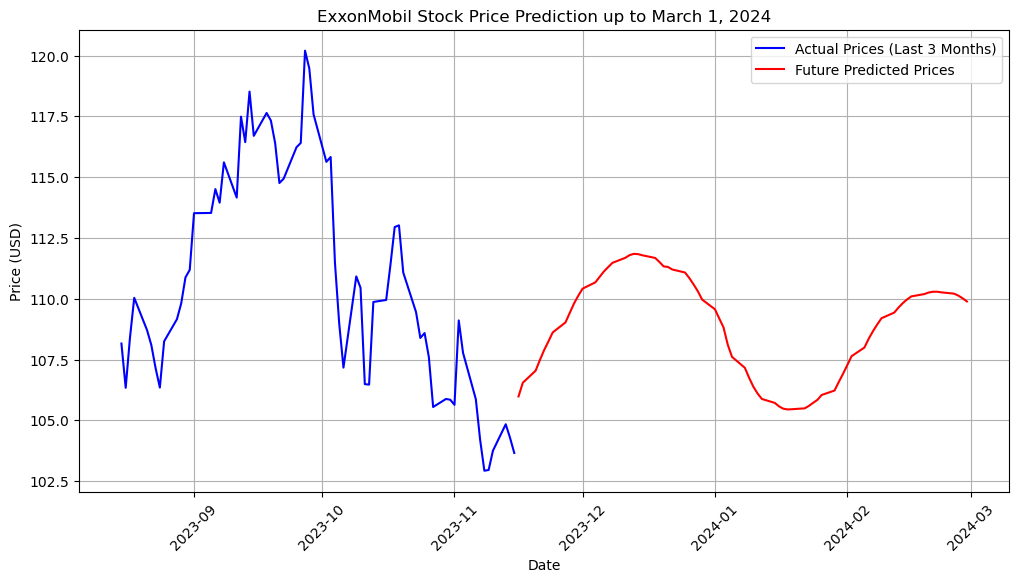

In [101]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Limit the actual prices to the last three months
three_months_ago = original_df.index.max() - pd.DateOffset(months=3)
limited_actual = original_df[three_months_ago:]

# Plot the last three months of actual prices
plt.plot(limited_actual['Close'], label='Actual Prices (Last 3 Months)', color='blue')

# Create a date range for the future predictions, starting from the day after the last actual data point
future_dates = pd.date_range(start=limited_actual.index[-1] + pd.Timedelta(days=1), periods=len(future_predictions_scaled), freq='B')

# Plot the future predicted prices
plt.plot(future_dates, future_predictions_scaled[:, 0], label='Future Predicted Prices', color='red')

# Add plot details
plt.title('ExxonMobil Stock Price Prediction up to March 1, 2024')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()
